# Data Preprocessing for MAG7 Stock Analysis
This notebook processes the cleaned MAG7 stock data to compute:
- Daily log returns
- Realized volatility (per stock)
- Equal-weight portfolio returns and realized volatility
- Window selection and transformations

## Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

colors = ['#E31A1C', '#1F78B4', '#33A02C', '#FF7F00', '#6A3D9A', '#FFD700', '#A65628']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# load data
df = pd.read_csv('./data/processed/mag7_prices_cleaned.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Data loaded: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Tickers: {sorted(df['Ticker'].unique())}")
print(f"\nFirst few rows:")
print(df.head())

Data loaded: (19222, 9)
Date range: 2015-01-02 00:00:00 to 2025-12-02 00:00:00
Tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

First few rows:
        Date Ticker       Open       High        Low      Close     Volume  \
0 2015-01-02   AAPL  24.694243  24.705328  23.798608  24.237558  212818400   
1 2015-01-05   AAPL  24.006990  24.086799  23.368519  23.554739  257142000   
2 2015-01-06   AAPL  23.619031  23.816336  23.195599  23.556957  263188400   
3 2015-01-07   AAPL  23.765354  23.987046  23.654508  23.887285  160423600   
4 2015-01-08   AAPL  24.215389  24.862728  24.097891  24.805088  237458000   

   Price_Range_Pct  Daily_Return  
0         3.740971           NaN  
1         3.049410     -2.817195  
2         2.635049      0.009417  
3         1.392111      1.402252  
4         3.083390      3.842223  


## Compute Daily Log Returns
Log returns are more suitable for statistical modeling and aggregation.

In [18]:
# calculate log returns
df['Log_Return'] = df.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))

# pivot to wide format
returns_pivot = df.pivot(index='Date', columns='Ticker', values='Log_Return')

print("Log returns summary:")
print(returns_pivot.describe())
print(f"\nMissing values per ticker:")
print(returns_pivot.isnull().sum())

# drop first row with nans
returns_pivot = returns_pivot.dropna()
print(f"\nReturns shape after cleaning: {returns_pivot.shape}")

Log returns summary:
Ticker         AAPL         AMZN         GOOG         META         MSFT  \
count   2745.000000  2745.000000  2745.000000  2745.000000  2745.000000   
mean       0.000899     0.000991     0.000910     0.000771     0.000914   
std        0.018211     0.020719     0.018146     0.023899     0.016957   
min       -0.137708    -0.151398    -0.117667    -0.306390    -0.159453   
25%       -0.007335    -0.008840    -0.007263    -0.009476    -0.006750   
50%        0.001000     0.001101     0.001293     0.000981     0.000954   
75%        0.010021     0.011502     0.009970     0.012109     0.009394   
max        0.142617     0.132178     0.148872     0.209308     0.132929   

Ticker         NVDA         TSLA  
count   2745.000000  2745.000000  
mean       0.002160     0.001231  
std        0.030533     0.036347  
min       -0.207711    -0.236518  
25%       -0.012513    -0.016686  
50%        0.002657     0.001258  
75%        0.017598     0.019394  
max        0.260876    

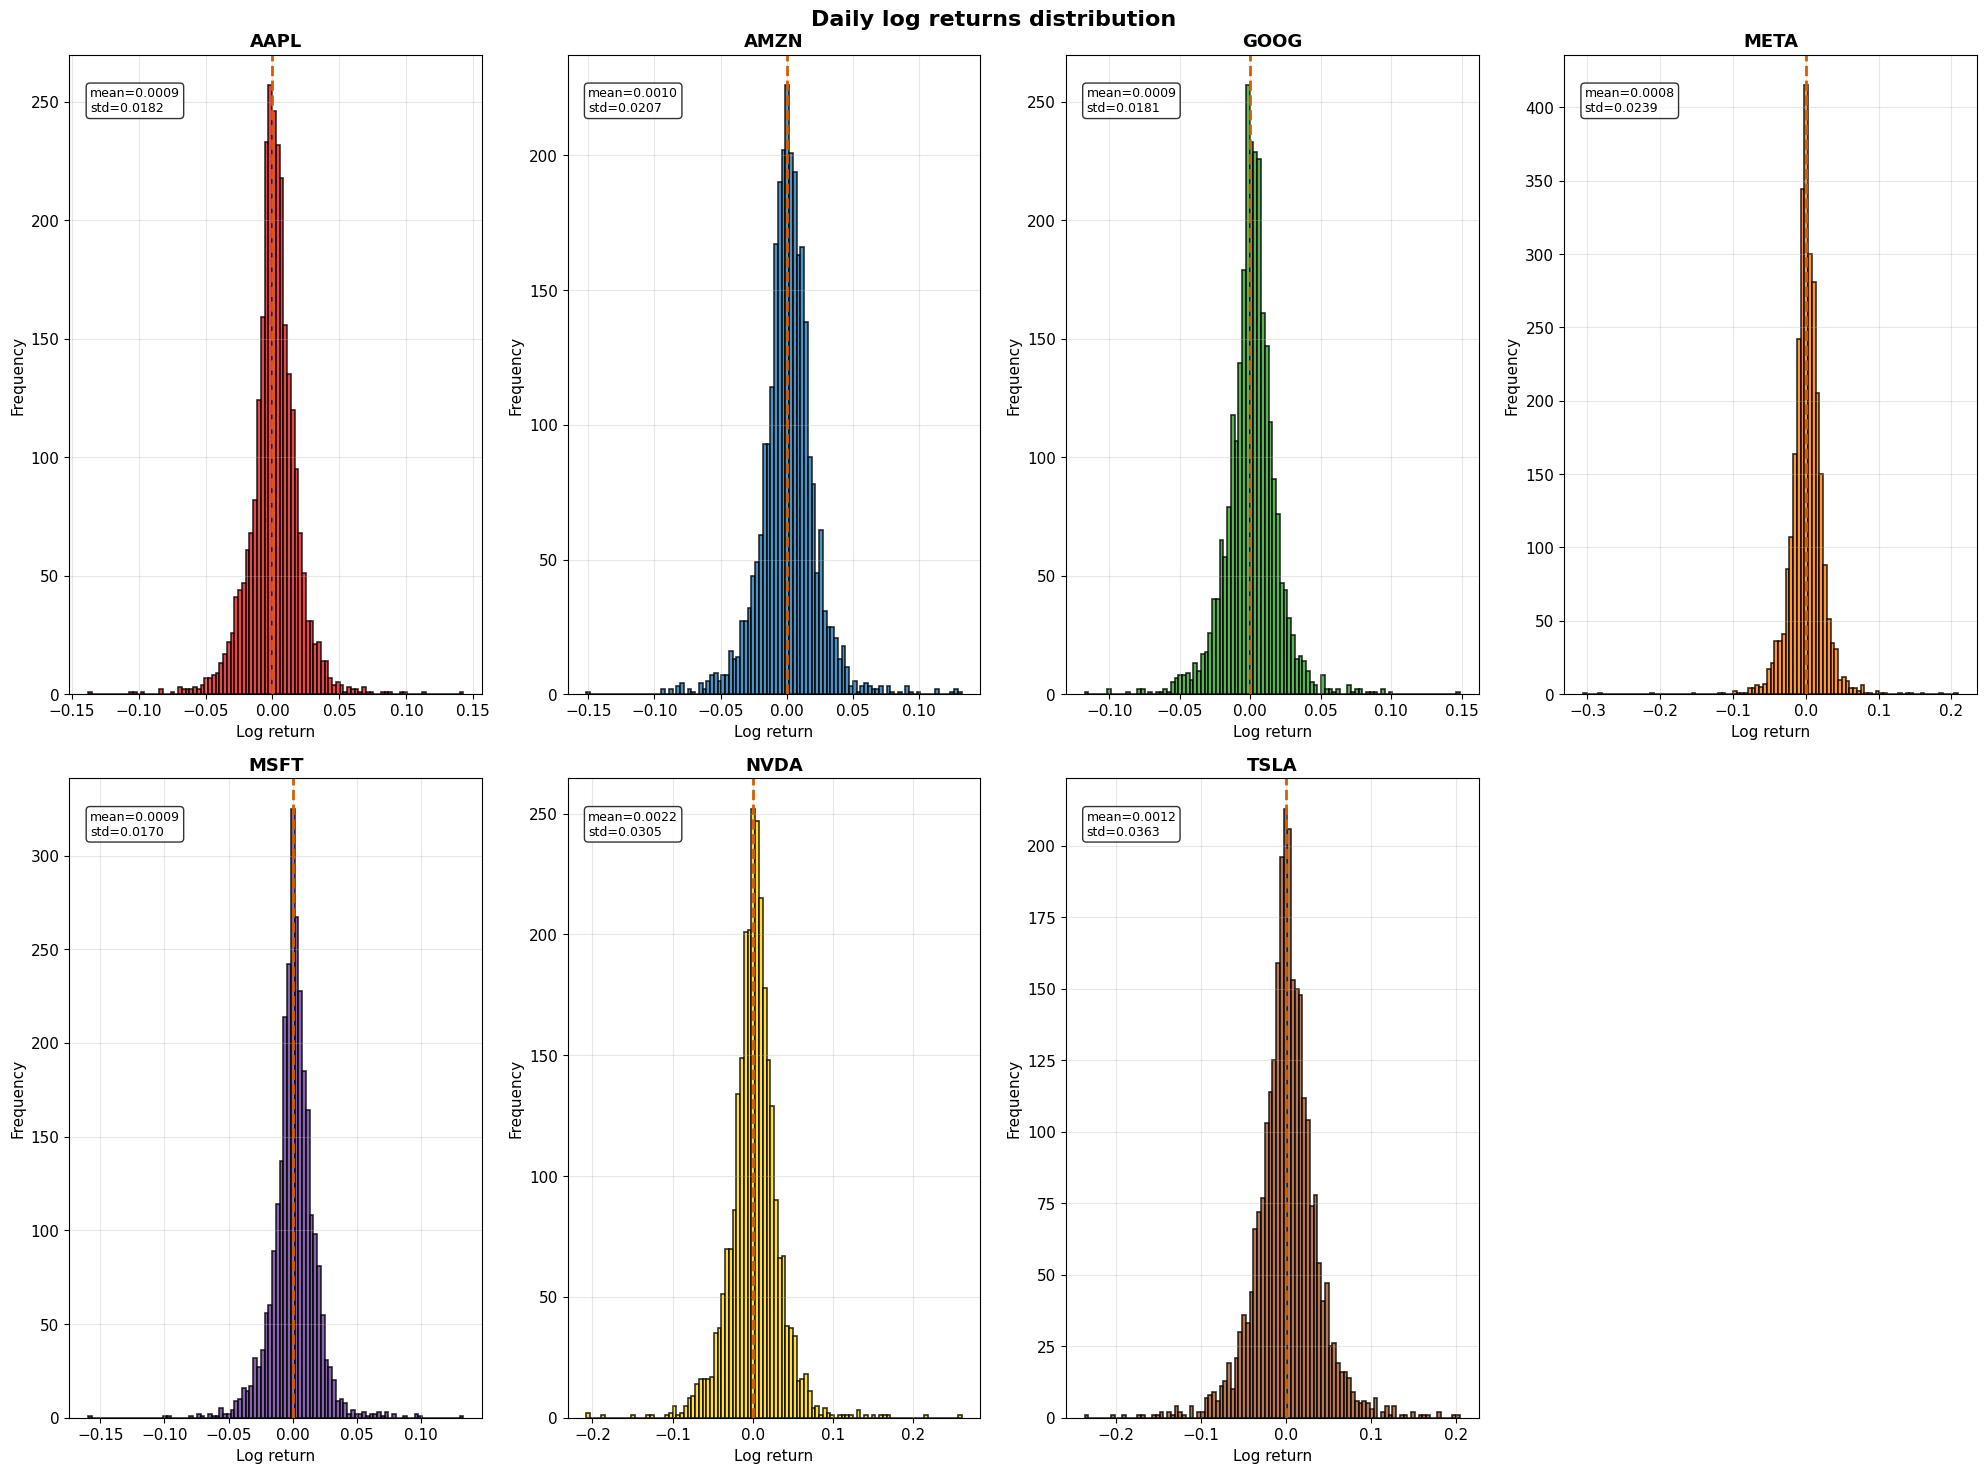

In [ ]:
# plot return distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(returns_pivot.columns)):
    axes[idx].hist(returns_pivot[ticker], bins=100, alpha=0.8, 
                   color=colors[idx], edgecolor='black', linewidth=1.2)
    axes[idx].axvline(x=0, color='#D55E00', linestyle='--', linewidth=2)
    axes[idx].set_title(f'{ticker}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Log return', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].grid(True, alpha=0.3, linewidth=0.8)
    
    # add stats
    mean_ret = returns_pivot[ticker].mean()
    std_ret = returns_pivot[ticker].std()
    axes[idx].text(0.05, 0.95, f'mean={mean_ret:.4f}\nstd={std_ret:.4f}', 
                   transform=axes[idx].transAxes, verticalalignment='top',
                   fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[7].axis('off')

plt.suptitle('Daily log returns distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

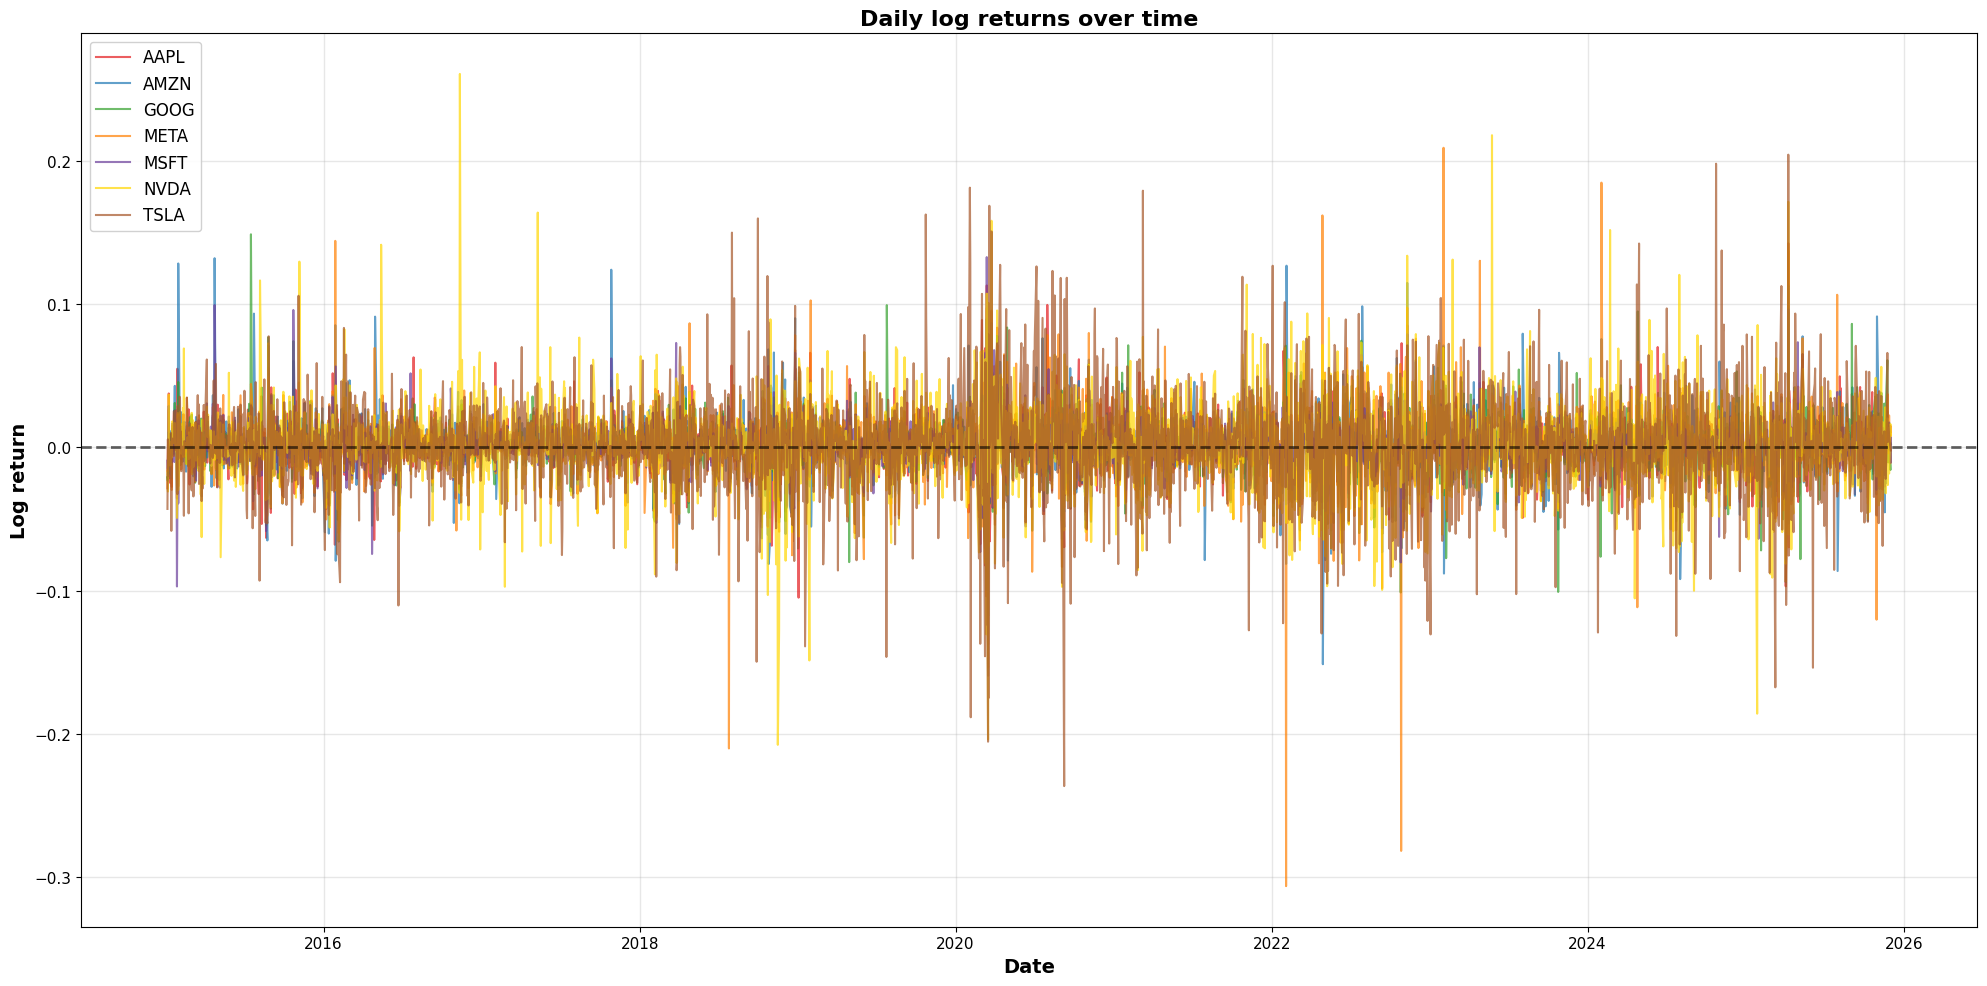


Log returns show volatility clustering


In [ ]:
# plot returns time series
fig, ax = plt.subplots(figsize=(20, 10))
for idx, ticker in enumerate(sorted(returns_pivot.columns)):
    ax.plot(returns_pivot.index, returns_pivot[ticker], 
            label=ticker, linewidth=1.5, alpha=0.7, color=colors[idx])

ax.axhline(y=0, color='#000000', linestyle='--', linewidth=2, alpha=0.6)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Log return', fontsize=14, fontweight='bold')
ax.set_title('Daily log returns over time', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

print("\nLog returns show volatility clustering")

## Realized Volatility Calculation
Calculate realized volatility using a 21-day rolling window for volatility forecasting.

In [21]:
# volatility calculation function
def calculate_realized_volatility(returns, window=21, annualize=True):
    rv = returns.rolling(window=window).std()
    if annualize:
        rv = rv * np.sqrt(252)  # annualize for 252 trading days
    return rv

# calculate volatility for all stocks
rv_21d = returns_pivot.apply(lambda col: calculate_realized_volatility(col))

print("Realized volatility summary:")
print(rv_21d.describe())

Realized volatility summary:
Ticker         AAPL         AMZN         GOOG         META         MSFT  \
count   2725.000000  2725.000000  2725.000000  2725.000000  2725.000000   
mean       0.261711     0.301532     0.265831     0.334692     0.243294   
std        0.124571     0.134251     0.114414     0.183358     0.120365   
min        0.077741     0.077475     0.060901     0.069738     0.054746   
25%        0.184124     0.198233     0.180237     0.219566     0.165478   
50%        0.236195     0.271507     0.247466     0.286283     0.217994   
75%        0.306450     0.382054     0.331529     0.399094     0.296349   
max        1.068829     0.772458     0.893333     1.198494     1.130667   

Ticker         NVDA         TSLA  
count   2725.000000  2725.000000  
mean       0.447450     0.533086  
std        0.191599     0.218497  
min        0.139772     0.168154  
25%        0.310013     0.370517  
50%        0.390086     0.494480  
75%        0.552495     0.635616  
max        1.39

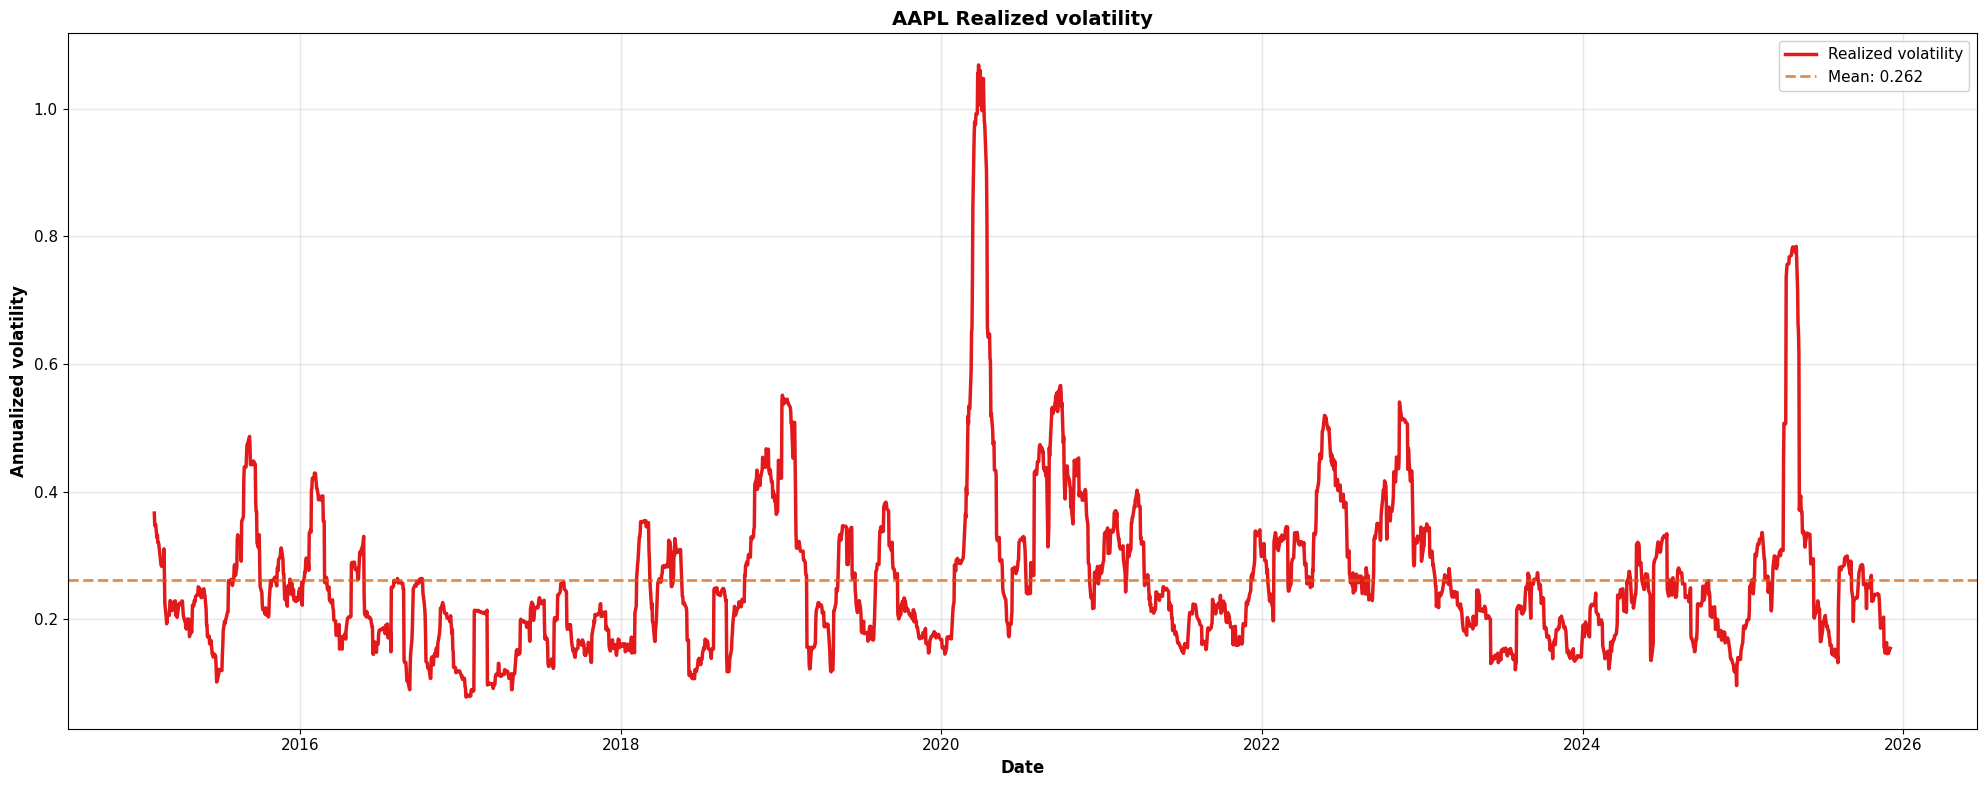

In [ ]:
# plot volatility for example stock
fig, ax = plt.subplots(figsize=(20, 8))

ticker_example = 'AAPL'
rv_example = rv_21d[ticker_example]

ax.plot(rv_example.index, rv_example, linewidth=2.5, color=colors[0], label='Realized volatility')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Annualized volatility', fontsize=12, fontweight='bold')
ax.set_title(f'{ticker_example} Realized volatility', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linewidth=1)

# add mean line
mean_rv = rv_example.dropna().mean()
ax.axhline(y=mean_rv, color='#D55E00', linestyle='--', 
          linewidth=2, alpha=0.7, label=f'Mean: {mean_rv:.3f}')
ax.legend(fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.show()

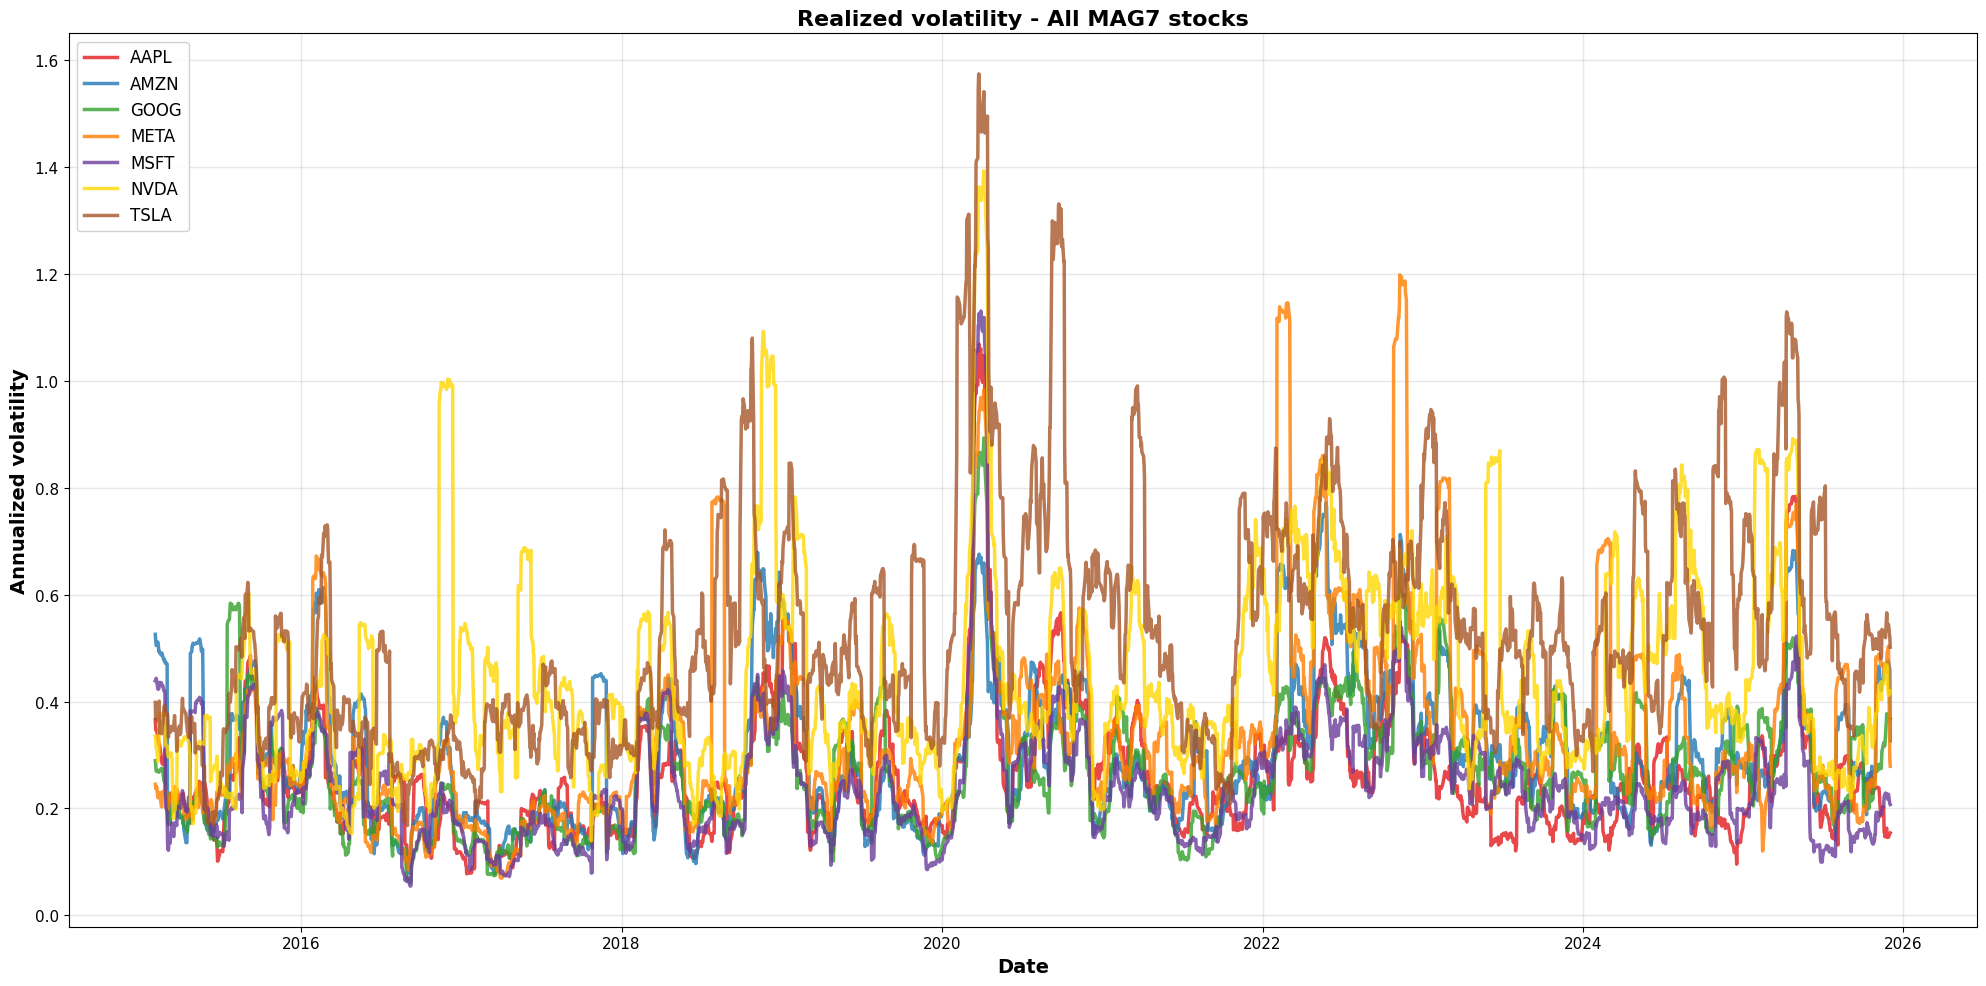


Mean annualized volatility by stock:
Ticker
TSLA    0.533086
NVDA    0.447450
META    0.334692
AMZN    0.301532
GOOG    0.265831
AAPL    0.261711
MSFT    0.243294
dtype: float64


In [ ]:
# plot all stocks volatility
rv_21d_clean = rv_21d.dropna()

fig, ax = plt.subplots(figsize=(20, 10))
for idx, ticker in enumerate(sorted(rv_21d_clean.columns)):
    ax.plot(rv_21d_clean.index, rv_21d_clean[ticker], label=ticker, 
            linewidth=2.5, alpha=0.8, color=colors[idx])

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized volatility', fontsize=14, fontweight='bold')
ax.set_title('Realized volatility - All MAG7 stocks', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

print("\nMean annualized volatility by stock:")
print(rv_21d_clean.mean().sort_values(ascending=False))

## Equal-Weight Portfolio Construction
Construct MAG7 equal-weight portfolio returns and realized volatility.

Equal-weight portfolio returns summary:
count    2745.000000
mean        0.001125
std         0.017929
min        -0.147613
25%        -0.006749
50%         0.002032
75%         0.010623
max         0.137174
dtype: float64

Annualized return: 0.2836
Annualized volatility: 0.2846
Sharpe ratio: 0.9963


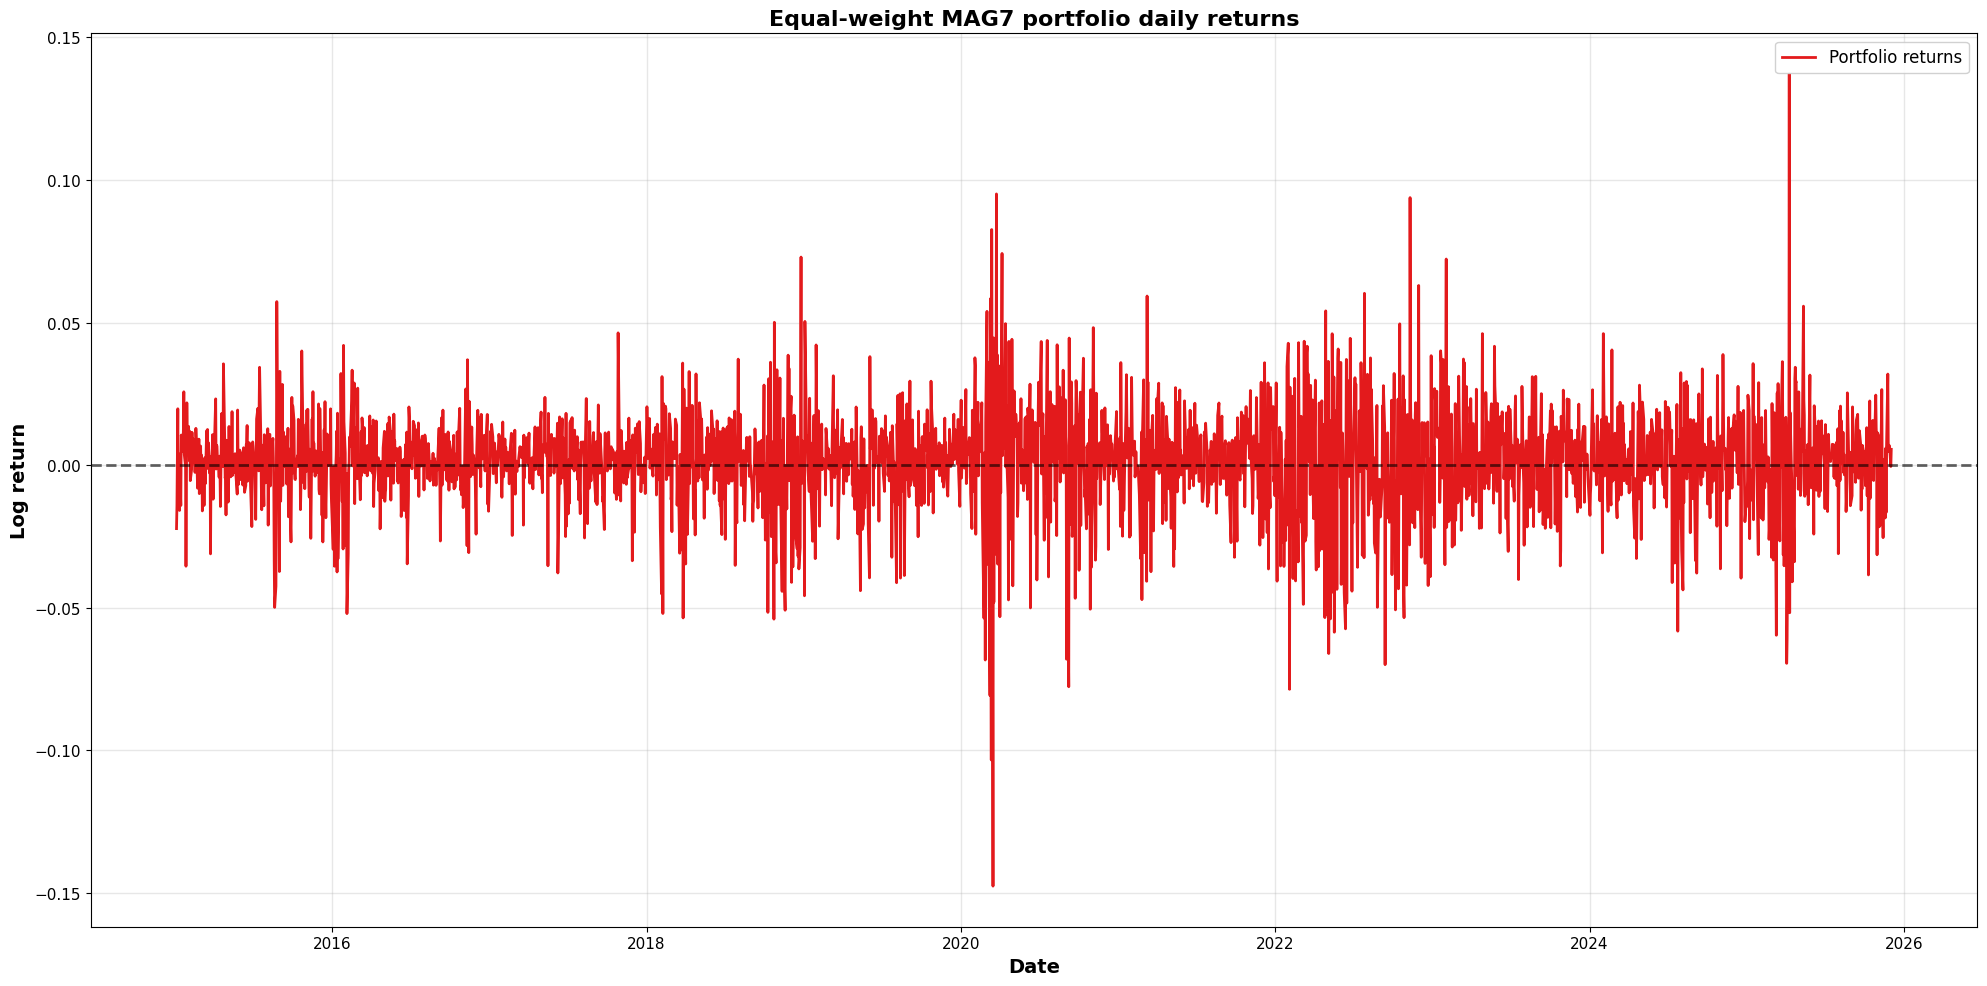

In [ ]:
# equal weight portfolio returns
portfolio_returns = returns_pivot.mean(axis=1)

print("Equal-weight portfolio returns summary:")
print(portfolio_returns.describe())
print(f"\nAnnualized return: {portfolio_returns.mean() * 252:.4f}")
print(f"Annualized volatility: {portfolio_returns.std() * np.sqrt(252):.4f}")
print(f"Sharpe ratio: {(portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252):.4f}")

# plot portfolio returns
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(portfolio_returns.index, portfolio_returns, linewidth=2, 
        color=colors[0], label='Portfolio returns')
ax.axhline(y=0, color='#000000', linestyle='--', linewidth=2, alpha=0.6)
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Log return', fontsize=14, fontweight='bold')
ax.set_title('Equal-weight MAG7 portfolio daily returns', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

In [25]:
# portfolio volatility
portfolio_rv_21d = calculate_realized_volatility(portfolio_returns)

print("Portfolio realized volatility summary:")
print(f"Mean: {portfolio_rv_21d.dropna().mean():.4f}")
print(f"Std: {portfolio_rv_21d.dropna().std():.4f}")
print(f"Min: {portfolio_rv_21d.dropna().min():.4f}")
print(f"Max: {portfolio_rv_21d.dropna().max():.4f}")

Portfolio realized volatility summary:
Mean: 0.2565
Std: 0.1263
Min: 0.0674
Max: 1.0020


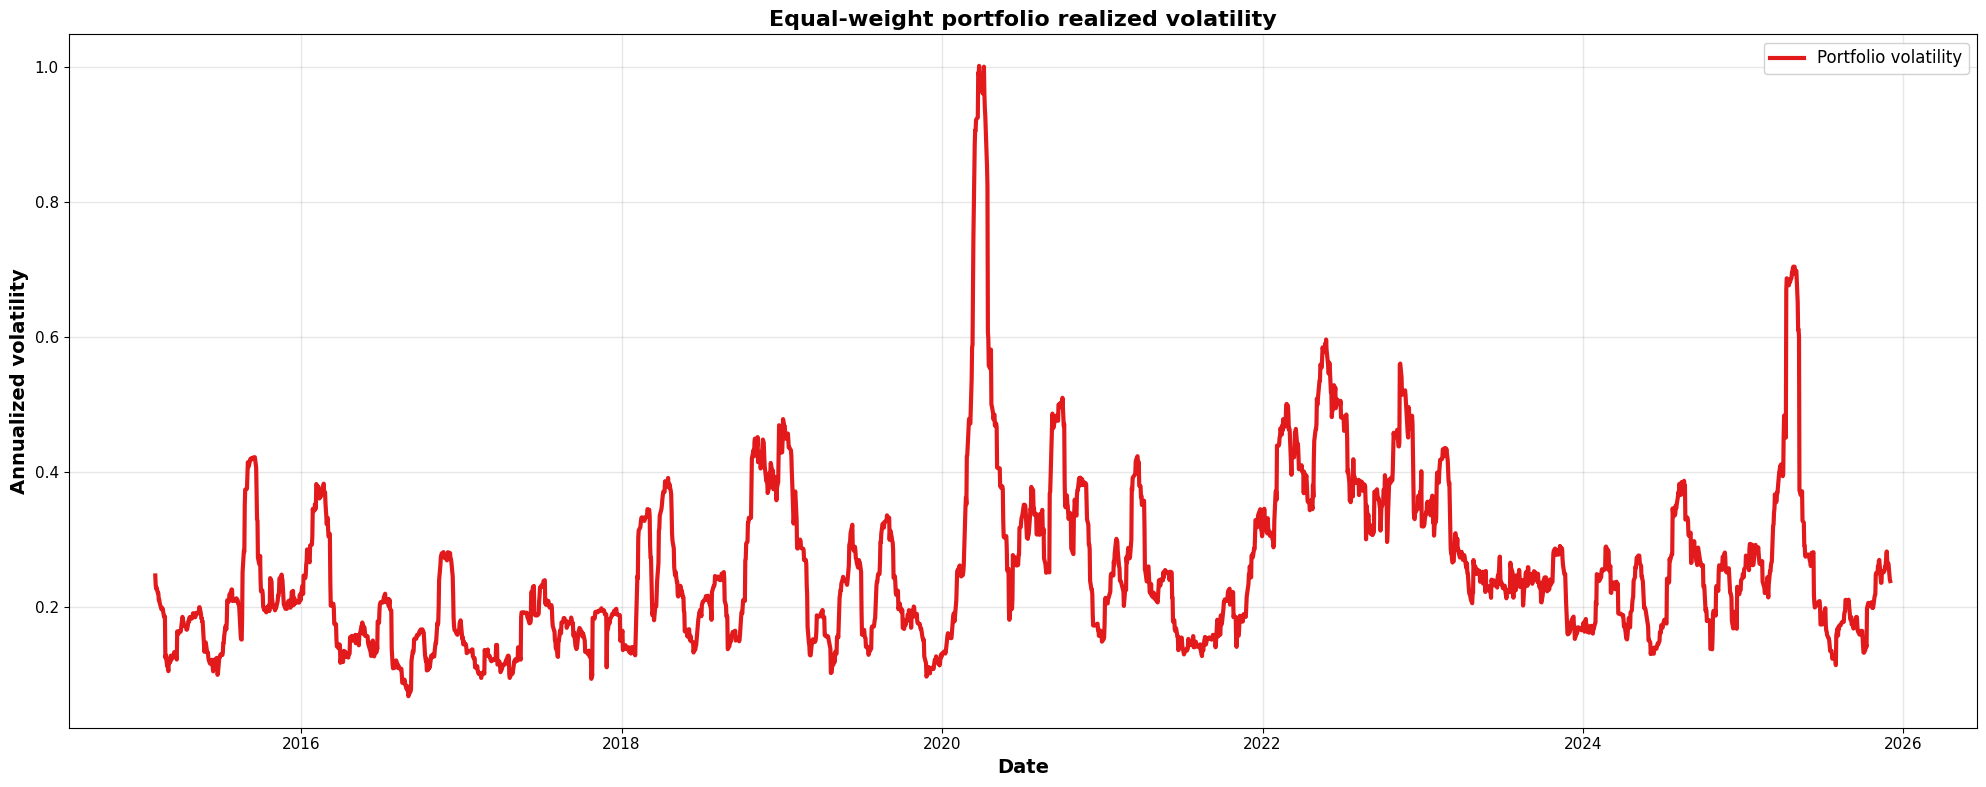


Portfolio diversification reduces volatility compared to individual stocks


In [ ]:
# plot portfolio volatility
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(portfolio_rv_21d.index, portfolio_rv_21d, label='Portfolio volatility', 
        linewidth=3, color=colors[0])

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized volatility', fontsize=14, fontweight='bold')
ax.set_title('Equal-weight portfolio realized volatility', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

print("\nPortfolio data ready for forecasting models")

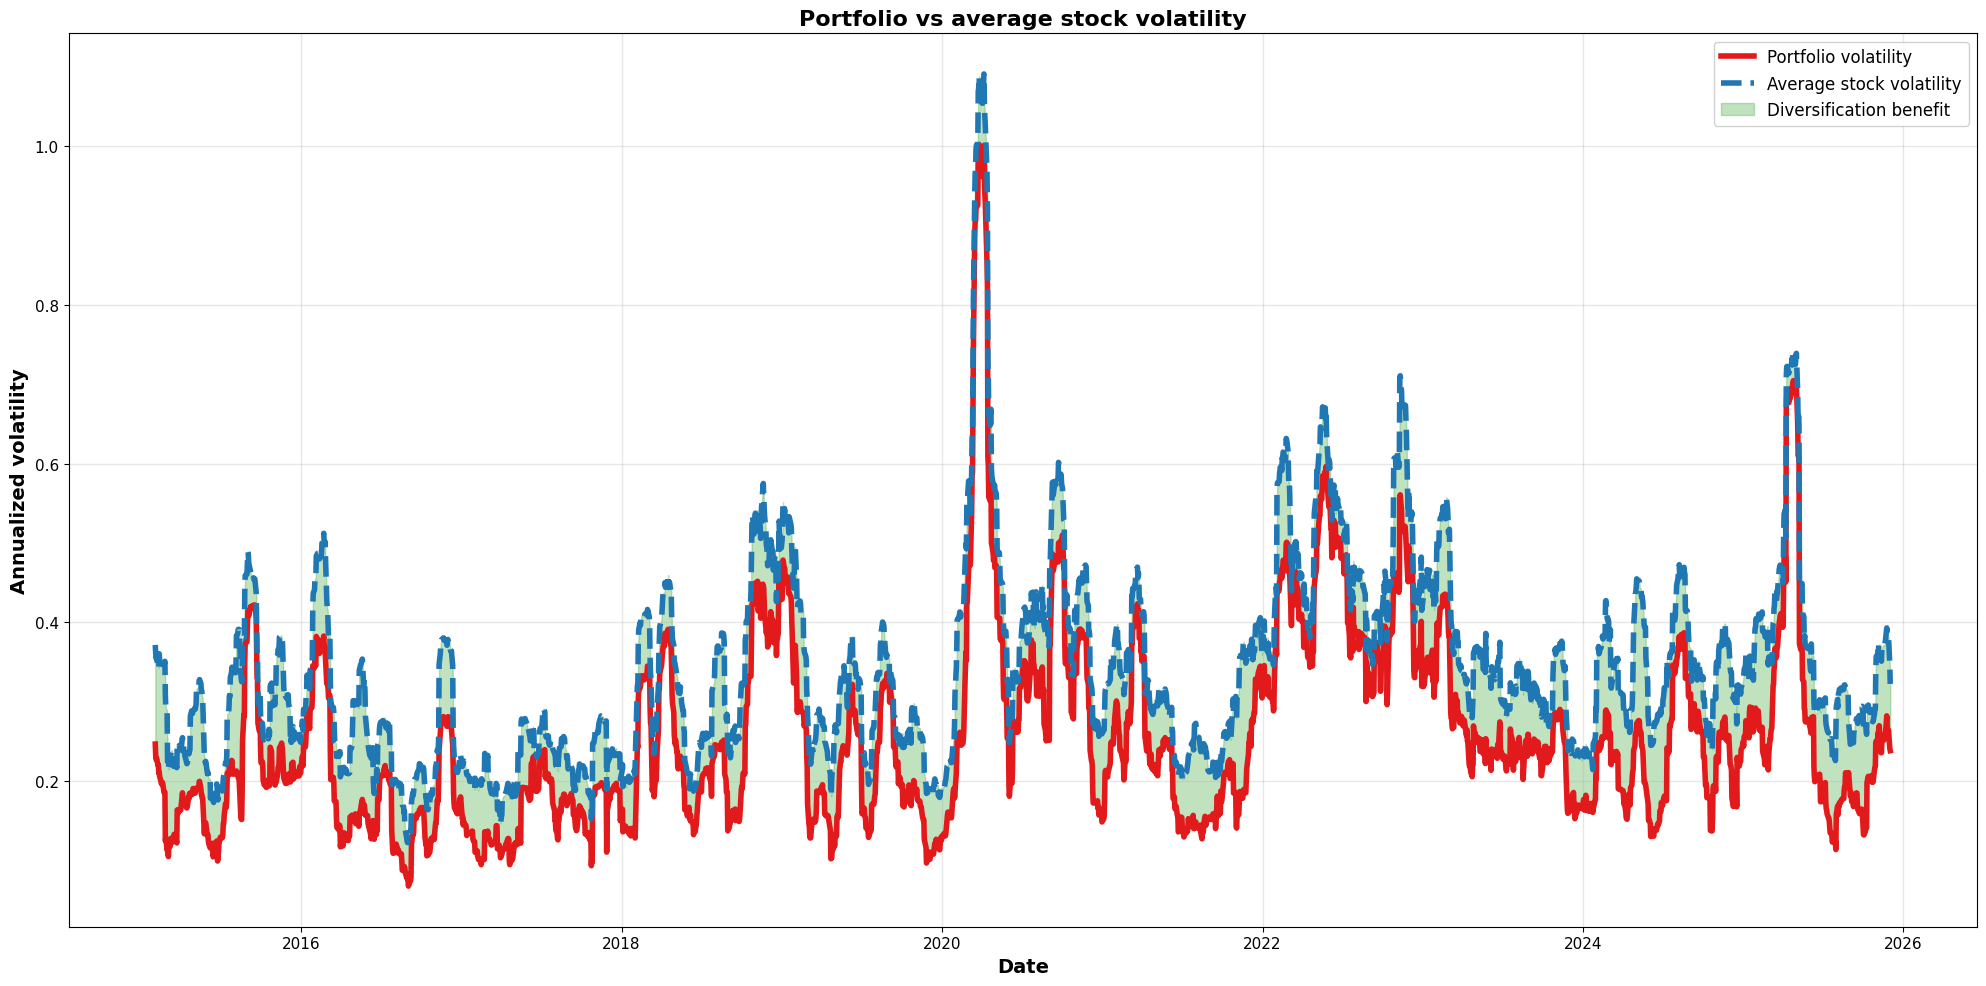


Average diversification benefit: 0.0845
Volatility reduction: 24.79%


In [ ]:
# compare portfolio vs individual stock volatility
fig, ax = plt.subplots(figsize=(20, 10))

# average individual stock volatility
avg_stock_rv = rv_21d_clean.mean(axis=1)

# align data
aligned_data = pd.DataFrame({
    'portfolio_rv': portfolio_rv_21d,
    'avg_stock_rv': avg_stock_rv
}).dropna()

# plot comparison
ax.plot(aligned_data.index, aligned_data['portfolio_rv'], label='Portfolio volatility', 
        linewidth=4, color=colors[0])
ax.plot(aligned_data.index, aligned_data['avg_stock_rv'], label='Average stock volatility', 
        linewidth=4, color=colors[1], linestyle='--')

# diversification benefit area
diversification_benefit = aligned_data['avg_stock_rv'] - aligned_data['portfolio_rv']
ax.fill_between(aligned_data.index, aligned_data['portfolio_rv'], aligned_data['avg_stock_rv'], 
                alpha=0.3, color=colors[2], label='Diversification benefit')

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized volatility', fontsize=14, fontweight='bold')
ax.set_title('Portfolio vs average stock volatility', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

print(f"\nAverage diversification benefit: {diversification_benefit.mean():.4f}")
print(f"Volatility reduction: {(diversification_benefit.mean() / aligned_data['avg_stock_rv'].mean() * 100):.2f}%")
print("\nData preprocessing complete - ready for modeling")

## Summary Statistics
Final summary of all processed data.

In [34]:
# summary statistics
summary_data = []

for ticker in sorted(returns_pivot.columns):
    summary_data.append({
        'Ticker': ticker,
        'Mean_return_daily': returns_pivot[ticker].mean(),
        'Std_return_daily': returns_pivot[ticker].std(),
        'Mean_volatility_annualized': rv_21d[ticker].dropna().mean(),
        'Std_volatility': rv_21d[ticker].dropna().std()
    })

# add portfolio
summary_data.append({
    'Ticker': 'PORTFOLIO',
    'Mean_return_daily': portfolio_returns.mean(),
    'Std_return_daily': portfolio_returns.std(),
    'Mean_volatility_annualized': portfolio_rv_21d.dropna().mean(),
    'Std_volatility': portfolio_rv_21d.dropna().std()
})

summary_df = pd.DataFrame(summary_data)
print("Summary statistics")
print(summary_df.to_string(index=False))

# key performance metrics
print("\nPortfolio performance")
print(f"Annualized return: {portfolio_returns.mean() * 252:.3f}")
print(f"Annualized volatility: {portfolio_returns.std() * np.sqrt(252):.3f}")
print(f"Sharpe ratio: {(portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252):.3f}")
print(f"\nMean realized volatility: {rv_21d.mean().mean():.3f}")
print(f"Portfolio realized volatility: {portfolio_rv_21d.dropna().mean():.3f}")

Summary statistics
   Ticker  Mean_return_daily  Std_return_daily  Mean_volatility_annualized  Std_volatility
     AAPL           0.000899          0.018211                    0.261711        0.124571
     AMZN           0.000991          0.020719                    0.301532        0.134251
     GOOG           0.000910          0.018146                    0.265831        0.114414
     META           0.000771          0.023899                    0.334692        0.183358
     MSFT           0.000914          0.016957                    0.243294        0.120365
     NVDA           0.002160          0.030533                    0.447450        0.191599
     TSLA           0.001231          0.036347                    0.533086        0.218497
PORTFOLIO           0.001125          0.017929                    0.256544        0.126309

Portfolio performance
Annualized return: 0.284
Annualized volatility: 0.285
Sharpe ratio: 0.996

Mean realized volatility: 0.341
Portfolio realized volatility: 0

## Export Processed Data
Save the processed time series for volatility forecasting models.

In [35]:
# export data
output_dir = './data/processed/'

# log returns
returns_pivot.to_csv(f'{output_dir}returns_log.csv')
print(f"Saved: returns_log.csv ({returns_pivot.shape})")

# realized volatility (all stocks)
rv_21d.to_csv(f'{output_dir}volatility_21d_annualized.csv')
print(f"Saved: volatility_21d_annualized.csv ({rv_21d.shape})")

# portfolio data
portfolio_data = pd.DataFrame({
    'Date': portfolio_returns.index,
    'Portfolio_Return': portfolio_returns.values,
    'Portfolio_RV_21d': portfolio_rv_21d.values
})
portfolio_data.to_csv(f'{output_dir}portfolio_equal_weight.csv', index=False)
print(f"Saved: portfolio_equal_weight.csv ({portfolio_data.shape})")

# primary forecasting target
volatility_target = pd.DataFrame({
    'Date': portfolio_rv_21d.index,
    'Volatility': portfolio_rv_21d.values
}).dropna()
volatility_target.to_csv(f'{output_dir}volatility_target.csv', index=False)
print(f"Saved: volatility_target.csv ({volatility_target.shape}) - Primary forecasting target")

print("\nData export complete")

Saved: returns_log.csv ((2745, 7))
Saved: volatility_21d_annualized.csv ((2745, 7))
Saved: portfolio_equal_weight.csv ((2745, 3))
Saved: volatility_target.csv ((2725, 2)) - Primary forecasting target

Data export complete
Saved: volatility_21d_annualized.csv ((2745, 7))
Saved: portfolio_equal_weight.csv ((2745, 3))
Saved: volatility_target.csv ((2725, 2)) - Primary forecasting target

Data export complete


In [36]:
# exported files summary
print("Exported files")
print("\n1. volatility_target.csv")
print("   - Main target for ARIMA/Prophet forecasting")
print("   - Portfolio volatility time series")

print("\n2. returns_log.csv")
print("   - Log returns for feature engineering")
print("   - All MAG7 stocks")

print("\n3. volatility_21d_annualized.csv")
print("   - Individual stock volatilities")
print("   - For stock-specific modeling")

print("\n4. portfolio_equal_weight.csv")
print("   - Portfolio returns and volatility")
print("   - For portfolio analysis")

print("\nReady for forecasting models")

Exported files

1. volatility_target.csv
   - Main target for ARIMA/Prophet forecasting
   - Portfolio volatility time series

2. returns_log.csv
   - Log returns for feature engineering
   - All MAG7 stocks

3. volatility_21d_annualized.csv
   - Individual stock volatilities
   - For stock-specific modeling

4. portfolio_equal_weight.csv
   - Portfolio returns and volatility
   - For portfolio analysis

Ready for forecasting models
